# Multi layer neural networks

L = number of layers
n[L] = # of units in layer

n[2] = number of neurons in layer 2

a[l] = activation in layer l

X = a[0] input

a[L] or a[-1] = prediction of network 


## Deep representations

What is a deep neural network computing?

In face recognition:
- The first layer detects simple features like edges.
- Subsequent layers combine edges into shapes
- Final layers combine these parts into complete faces.

in audio processing: phonemes → words → phrases → sentences.

Each layer computes some more complex features than the last layer


## Circuit Theory
Some functions can be approximated compactly with deep networks but need exponentially more hidden neurons if it is shallow.

Example: computing many XOR gates with a shallow vs deep neural network

deep networks learn simple-to-complex hierarchical representations


# Deep learning building blocks
Each layer in a neural network performs forward propagation and backward propagation.

forward pass:
```python
for l in range(L):
    z[l] = W[l] @ a[l-1] + b[l]
    a[l] = g(z[l])
```

back prop

```python

da[L] = loss_derivative(a[L],y)
for l in range(L,1):
    dz[l] = da[l] @ g_prime(z[l])
    dw[l] = dz[l] @ a[l-1].T / m
    db[l] = np.mean(dz[l],axis=1,keep_dims=True)
    da[l-1] = W[l].T @ dz[l]
```

# Parameters & Hyperparameters

Parameters: w[L],b[L]

hyperparameter:
- learning rate
- num iterations
- num hidden layers and units
- activation functions

Hyper parameters determine final values of Parameters

Need to experiment with different hyper parameters for a new problem, trial and error processes of figuring out which hyper parameters are best for what problem


# Vectorized NN

In [3]:
import numpy as np
def relu_grad(input):
    return np.array(input >0).astype(float)
def relu_function(input):
    return np.maximum(input,0)
def tanh_derivative(x):
    return 1 - np.tanh(x)**2
def tanh_function(x):
    return np.tanh(x)
def sigmoid_function(x):
    return 1 / ( 1 + np.exp(-x))
def sigmoid_derivative(x):
    sigmoid = 1 / ( 1 + np.exp(-x))
    return sigmoid * (1 - sigmoid)
def bce_function(y_true, y_predicted):
    eps=1e-11
    #clip any value smaller than eps as log(0) == Nan
    y_predicted = np.clip(y_predicted, eps, 1 - eps)  
    loss = -np.mean(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))

    return loss

def bce_grad(y_true, y_pred):
    eps=1e-11
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true / y_pred) + (1 - y_true) / (1 - y_pred)

class Layer:
    def __init__(self,num_inputs,num_outputs,activation,activation_derivative):
        self.W = (np.random.rand(num_outputs,num_inputs) * 2 - 1 ) * 0.2
        self.b = np.zeros((num_outputs,1))
        self.activation = activation
        self.activation_derivative = activation_derivative
    def forward(self,prev_a):
        self.prev_a = prev_a
        # linear transformation 
        self.z = self.W @ prev_a + self.b
        # activation
        self.a = self.activation(self.z)
        return self.a

    def backward(self,da):
        # find dz using da received from layer+1 dJ/dz = dJ/da * da/dz
        # da/dz = dJ/da * activation derivative
        dz = da * self.activation_derivative(self.z)
        batch_size = self.prev_a.shape[1]

        #find dw: dz @ prev_a.T: (num_outputs, batch_size) @ (batch_size, num_inputs) = (num_outputs, num_inputs)
        # divide by batch size to get average over our batch
        self.dw = (dz @ self.prev_a.T) / batch_size
        #find db: similar to dw
        #use mean to find average gradient of each bias over our many batches
        self.db = np.sum(dz, axis=1, keepdims=True) # (8, 1)
        #find prev_da to send to layer-1
        #W.T @ dz: (num_inputs, num_outputs) @ (num_outputs, batch_size) = (num_inputs, batch_size)
        prev_da = self.W.T @ dz  
        return prev_da

    def tune(self,learning_rate):
        #update weights and biases with gradient after back prop
        self.W -= learning_rate * self.dw
        self.b -= learning_rate * self.db
class MLP:
    def __init__(self,layers:list[Layer],loss_fun,loss_grad):
        self.loss_fun = loss_fun
        self.loss_grad = loss_grad
        self.layers:list[Layer] = layers
    def forward(self,activations,y_true):
        self.y_true = y_true
        self.activations = activations
        for layer in self.layers:
            self.activations = layer.forward(self.activations)
        self.loss = self.loss_fun(y_true,self.activations)
        return self.loss

    def backward(self):
        #find gradient of our loss function
        j_wrt_a = self.loss_grad(self.y_true,self.activations)
        #send back through to each layer to update dW and db for each layer
        for layer in reversed(self.layers):
            j_wrt_a = layer.backward(j_wrt_a)
    
    def tune(self,learning_rate):
        for layer in self.layers:
            layer.tune(learning_rate)



# see how well it fits a simple curve

would probably work better with tanh over relu activations due to the smooth curve

In [4]:
fun = lambda x :  4 * np.sin((2*np.cos(x))+1)
X = np.linspace(0,10,60)
y = np.array([fun(x) for x in X])
X = (X - X.mean()) / X.std()


X = X.reshape(1,-1)
y = y.reshape(1,-1)

6.796838974799512
6.285931747736034
6.476267621566975
6.2165338629402145
5.852202026488437
5.511703196056448
5.263409453984791
4.945814221681089
4.699956051260486
4.278307809480378
2.3840619743036644
3.32051953434561
2.939968356298698
3.0239554952526664
1.72479147891474
2.4491269900079593
1.853061413181039
1.9452560430277044
1.4589692280908997
1.5412271924726175
1.2343735558520377
1.2166981485118575
1.131724169111311
1.3298316402336954
0.8638683266212318
0.9661057985849951
0.967977358104406
0.73459740415722
1.0175676005300405
1.1642469518958818
1.0247105685860889
0.9545971422665084
1.0776100342169754
0.8226124043397504
1.0902586500709122
1.0491418461679753
0.9290544087562943
1.0590872427353017
0.9322736507477489
0.9180181729462232
0.8946872683075421
0.9660095872158334
1.1209897332438055
0.8257542143734273
0.9300844022825363
0.7465383178498494
0.8913976129260933
0.841881439653319
0.7283768136733199
0.6336093243537458
0.7707220198248403
0.5928952709176538
0.8598810355155911
0.75589775653

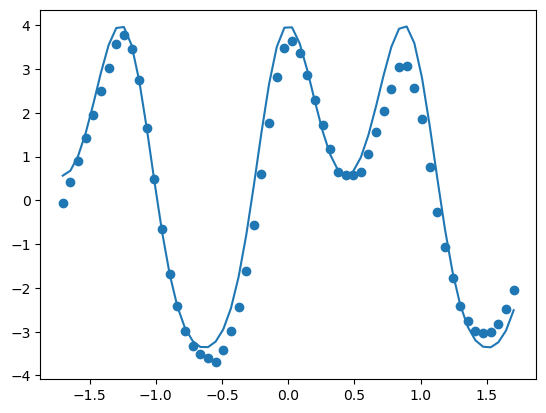

In [13]:
import matplotlib.pyplot as plt
def mse_function(y_true, y_predicted):
    return np.mean((y_true - y_predicted)**2)

def mse_grad(y_true, y_pred):
    return 2 * (y_pred - y_true) / len(y_true)
layers = [
    Layer(1, 200, relu_function, relu_grad),
    Layer(200, 200, relu_function, relu_grad),
    Layer(200, 1, lambda x:x, lambda x : 1),
]

mlp = MLP(layers,loss_fun = mse_function , loss_grad=mse_grad )
learning_rate = 0.01
for i in range(10000):
    loss = mlp.forward(
        activations= X,
        y_true=y)
    mlp.backward()
    mlp.tune(learning_rate)

    if i % 100 == 0:
        print(loss)

plt.plot(X[0], y[0])  
plt.scatter(X,mlp.activations[0])
plt.show()